In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  


sys.path.append('/Users/kemran/Desktop/work_files/python_files') 
from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [74]:
query = '''WITH all_info AS (SELECT  
        s.user_id AS user_id,
        t3.created_at::date as trial_start,
        s.id AS id,
       -- leadInFrame(id) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_id,
        i.state as invoice_state,
        --leadInFrame(invoice_state) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_invoice_state,
        i.id as invoice_id,
        i.created_at as invoice_created_at,
        --leadInFrame(invoice_created_at) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_invoice_created_at,  
      --  next_invoice_created_at::date - invoice_created_at::date delta_date,
        i.price_cents AS price_cents,
        i.price_currency AS price_currency,
        i.refund_amount_cents AS refund_amount_cents,
        t4.bonus_title_new AS bonus_title_new,
        ROW_NUMBER() OVER (PARTITION BY user_id,id,user_type,invoice_state ORDER BY invoice_created_at) AS rn_num,
        CASE WHEN price_cents<=100 AND invoice_state='success' THEN 'trial'
             WHEN price_cents<=100 AND invoice_state IN ('failure','initial') THEN 'not_success_trial'
             ELSE 'subs'
             END user_type,
        leadInFrame(user_type) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_user_type, 
        t2.renewal_off_date AS renewal_off_date,
        CASE WHEN renewal_off_date!='1970-01-01' THEN 1 ELSE 0 END unsubscribe_type,
        t3.free_days AS free_days,
        t3.offer_duration AS offer_duration,
        t3.promo_type,
        i.paid_at AS paid_at,
        --i.period_end,
        s.platform AS platform,
       -- i.payment_target,
        i.deleted_at,
        i.refunded_at
    FROM raw.viju__product_x__public__invoices i
    LEFT JOIN raw.viju__product_x__public__subscriptions s 
        ON i.subscription_id = s.id  
    LEFT JOIN (SELECT
                subscription_id,
                max(created_at) as renewal_off_date
                FROM raw.viju__product_x__public__subscription_cancel_reasons
                WHERE created_at >= '2022-03-01'
                 --AND subscription_id='74bcff94-4ada-40ef-85de-25074d615d57'
                GROUP by 1
                ) AS t2 ON i.subscription_id=t2.subscription_id
    INNER JOIN datamarts.marketing_dash AS t3 ON s.user_id=t3.user_id
    LEFT JOIN datamarts.mekhtiev_bonus_distr AS t4 ON t3.bonus_title=t4.bonus_title_old
    WHERE s.platform != 'api'
    ORDER BY s.user_id, invoice_created_at 
    )
--    
SELECT * FROM all_info
WHERE invoice_created_at::date BETWEEN '2025-03-10' AND '2025-03-23'
--AND user_type!='not_success_trial'
AND platform!='payture'
AND free_days!='28'
'''
df = execute(query,user='kmekhtiev')

#df['ends_at'] = pd.to_datetime(df['ends_at'])
#df['trial_date'] = pd.to_datetime(df['trial_date'])

Время выполнения функции: 9.3642 секунд



In [306]:
pd.read_csv('

,user_id,trial_start,id,invoice_state,invoice_id,invoice_created_at,price_cents,price_currency,refund_amount_cents,bonus_title_new,...,free_days,offer_duration,t3.promo_type,paid_at,platform,i.deleted_at,i.refunded_at,invoice_created_month,rn_num_2,max_rn
0,6989c5d9-7e7d-4e35-8000-6d6b6ede8fd8,2025-02-15,eb76bade-4304-481b-a2eb-0e7b356418de,success,5f7e47d9-f3fc-43b9-ae59-a686c061ebeb,2025-03-22,39900,RUB,0,,...,35,3 month,promo,2025-03-22 00:01:34.289,cloudpayments,NaT,NaT,2025-03,1,1
1,ae756ed1-6181-46dc-8002-1f44df95e8f8,2025-03-14,d01388e5-e420-499a-8c9d-1ca1b673406e,success,2217114b-c70b-4423-b295-06177db5213f,2025-03-14,0,RUB,0,Sharry 3 мес 399 \ 45 дней,...,45,3 month,promo,2025-03-14 14:30:55.189,cloudpayments,NaT,NaT,2025-03,1,1
2,10dab0eb-8c30-4c44-8002-7d95359601de,2025-02-09,bd0fbfa9-0ffd-42e1-bd06-27c63939a45d,failure,94334457-0a57-4c8e-8623-ec0b4883aa6b,2025-03-16,39900,RUB,0,,...,35,3 month,promo,NaT,cloudpayments,NaT,NaT,2025-03,1,4
3,10dab0eb-8c30-4c44-8002-7d95359601de,2025-02-09,bd0fbfa9-0ffd-42e1-bd06-27c63939a45d,failure,d90a0ce6-9aef-4eec-b1f2-baedea954702,2025-03-16,39900,RUB,0,,...,35,3 month,promo,NaT,cloudpayments,NaT,NaT,2025-03,2,4
4,10dab0eb-8c30-4c44-8002-7d95359601de,2025-02-09,bd0fbfa9-0ffd-42e1-bd06-27c63939a45d,failure,bd84bdbd-73d2-4444-8256-64ebb036f2d0,2025-03-16,39900,RUB,0,,...,35,3 month,promo,NaT,cloudpayments,NaT,NaT,2025-03,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20354,c99b154f-a4e3-488c-bffe-044fc3d0d9fc,1970-01-01,04dd243b-8fc4-46d8-89dd-2df17edfb235,initial,b20d9c59-56cd-46d7-b693-ee6d178ee82b,2025-03-23,5000,RUB,0,,...,0,,no_promo,NaT,cloudpayments,2025-03-23 17:55:56.689,NaT,2025-03,1,1
20355,c99b154f-a4e3-488c-bffe-044fc3d0d9fc,1970-01-01,0e9e8141-b44f-41cd-9b7f-764f28290e7a,initial,5efde9df-56f5-4f9a-ad2b-fbf8321036a9,2025-03-23,0,RUB,0,,...,0,,no_promo,NaT,cloudpayments,NaT,NaT,2025-03,1,1
20356,c99b154f-a4e3-488c-bffe-044fc3d0d9fc,1970-01-01,b4d16df0-1a91-4321-9238-cc096d39f5db,initial,04c276af-11ae-4837-b811-8a6018f2f7f9,2025-03-23,5000,RUB,0,,...,0,,no_promo,NaT,cloudpayments,NaT,NaT,2025-03,1,1
20357,2b1fb60a-3123-4e38-bfff-b6be48c5e0b0,2025-02-10,5d5c5175-2347-489c-a75b-628067ac87fc,failure,0cd37d7a-16b4-4174-818c-7dfce93902a5,2025-03-10,29900,RUB,0,Яндекс Директ. 1 месяц за 1 рубль.,...,30,1 month,promo,NaT,cloudpayments,NaT,NaT,2025-03,1,2


In [78]:
df['invoice_created_at'] =  df['invoice_created_at'].dt.strftime("%Y-%m-%d")
df['invoice_created_at'] =  pd.to_datetime(df['invoice_created_at'])
df['invoice_created_month'] = df['invoice_created_at'].dt.to_period('M')


df['trial_start'] =  pd.to_datetime(df['trial_start'])
#df['next_invoice_created_at'] =  df['next_invoice_created_at'].dt.strftime("%Y-%m-%d")
#df['next_invoice_created_at'] =  pd.to_datetime(df['next_invoice_created_at'])

In [80]:
df['rn_num_2'] = df.groupby(['user_id','id']).cumcount() + 1
df['max_rn'] = df.groupby(['user_id'])['rn_num_2'].transform('max')

In [ ]:
# df['trial_end'] = df['trial_start'] + + pd.to_timedelta(df['free_days'], unit='D')
# df['trial_end'] =  pd.to_datetime(df['trial_end'])

# df['rn_num_2'] = df.groupby(['user_id','id','invoice_created_at']).cumcount() + 1
# df['max_rn'] = df.groupby(['user_id'])['rn_num_2'].transform('max')

# df['next_invoice_state'] = df['next_invoice_state'].apply(lambda x: 'unsubscribe' if x == ''  else 
#                                                                'other' if x in ['initial','refunded','processing']
#                                                                else x)


# df[(df['max_rn']==df['rn_num_2']) & \
#    (df['trial_end']>='2025-03-03')\
#     & (df['trial_end']<='2025-03-23')].\
#     groupby('next_invoice_state')['user_id'].count()

# df_trial = df[(df['max_rn']==df['rn_num_2']) & (df['trial_end']>='2025-03-03') & (df['trial_end']<='2025-03-20')]

# df_trial.groupby('invoice_state')['user_id'].nunique()

In [ ]:
#df_trial_succes_failure = df_trial[~df_trial['invoice_state'].isin(['other','unsubscribe'])]

In [ ]:
#df_trial[~df_trial['invoice_state'].isin(['other','unsubscribe'])].groupby('invoice_state')['user_id'].nunique()

In [183]:
# Все пользователи у которых должно было быть списание
df_success_failure = df[(df['invoice_created_at']>='2025-03-10') & 
                        (df['invoice_created_at']<='2025-03-23') &
                        (df['max_rn'] == df['rn_num_2']) & 
                        (df['invoice_state'].isin(['success','failure'])) &
                        (df['trial_start']<'2025-03-10')]
                        #(df['free_days'].isin([3,30,35,14,45]))] # Убираем тех, кто стал триальщиком в этот период

In [185]:
df_success_failure.groupby('invoice_state')['user_id'].count()

invoice_state
failure    2047
success    2234
Name: user_id, dtype: int64

In [187]:
# df_subs_trial = pd.merge(df_all,df_trial_succes_failure['user_id'],how='left',on='user_id',indicator=True)
# df_subs_trial = df_subs_trial.rename(columns={'_merge': 'trial_subs'})

# df_subs_trial['trial_subs'] = df_subs_trial['trial_subs'].apply(lambda x:'subs' if x=='both' else 'trial')
# df_subs_trial = df_subs_trial[df_subs_trial['invoice_state'].isin(['failure','success'])]

In [189]:
# Дедупликация 
t = df_success_failure['user_id'].value_counts().reset_index()
t=t[t['count']>1]

df_subs_trial_wo_dubl = pd.merge(df_success_failure,t['user_id'],how='left',on='user_id',indicator='duplicate')
df_subs_trial_wo_dubl = df_subs_trial_wo_dubl[df_subs_trial_wo_dubl['duplicate']=='left_only']

df_subs_trial_wo_dubl['success_type'] = df_subs_trial_wo_dubl['invoice_state'].apply(lambda x:0 if x=='failure' else 1)

In [191]:
df_subs_trial_wo_dubl['user_id'].value_counts()

user_id
6989c5d9-7e7d-4e35-8000-6d6b6ede8fd8    1
fd2f0ecf-3e50-4c14-aa35-7f5748b622ad    1
7f21cbcf-d2fc-4ef1-a9f9-d1360594e042    1
1e0bcf7d-0583-40b4-a9fd-0ddad0a5b767    1
2a951b53-dce0-4fcb-a9fe-4aa0fa38726a    1
                                       ..
60b9c591-345e-4ff8-949d-6734862340f1    1
45556746-ce84-4e3c-94a5-b1303d99b095    1
9e6ca9f5-7020-431a-94a7-d780366bd722    1
c6b3a2ff-51d3-4a70-94a9-2a5b97eacb8c    1
2b1fb60a-3123-4e38-bfff-b6be48c5e0b0    1
Name: count, Length: 4275, dtype: int64

In [193]:
df_subs_trial_wo_dubl.groupby(['invoice_state'])['user_id'].count()

invoice_state
failure    2043
success    2232
Name: user_id, dtype: int64

# Основные вводные

In [196]:
num_of_bucket = 2

## Функция расчета абсолютного и относительного MDE конверсинной метрики

In [199]:
def mde_estimated_absolute (ttl_users,var,alpha,beta):
        t_alpha = stats.norm.ppf(1 - alpha /(num_of_bucket - 1) / 2, loc=0, scale=1)
        t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
        var = var * 2
        MDE=(t_alpha+t_beta) * np.sqrt(var  / ttl_users)
        return MDE

In [201]:
math.ceil(df_subs_trial_wo_dubl['user_id'].nunique())

4275

In [203]:
BOLD = "\033[1m"  
END = "\033[0m"  
ttl_users = math.ceil(df_subs_trial_wo_dubl['user_id'].nunique() / num_of_bucket)
var = df_subs_trial_wo_dubl['success_type'].var()
mean = df_subs_trial_wo_dubl['success_type'].mean()

mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean

print(f"{BOLD}Период - {'2 недели'}{END}") 
print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Среднияя конверсия в оплату:',round(mean,4))
print('Дисперсия:',round(var,4))
print('Число пользователей в группе:',math.ceil(ttl_users))
print("="*50)

Период - 2 недели
MDE абсолютный: 0.0428
MDE относительный: 0.082
Среднияя конверсия в оплату: 0.5221
Дисперсия: 0.2496
Число пользователей в группе: 2138


# Удаление выбросов

## Квантильный анализ

# Постстратификация

In [238]:
weights = df_subs_trial_wo_dubl['free_days'].value_counts(normalize=True).to_dict()
weights

{35: 0.5141520467836257,
 14: 0.22339181286549709,
 30: 0.12,
 45: 0.057777777777777775,
 0: 0.03695906432748538,
 3: 0.022690058479532163,
 59: 0.011695906432748537,
 121: 0.002105263157894737,
 90: 0.0016374269005847953,
 151: 0.0014035087719298245,
 182: 0.0009356725146198831,
 81: 0.00046783625730994154,
 80: 0.00046783625730994154,
 243: 0.00046783625730994154,
 335: 0.00046783625730994154,
 358: 0.00023391812865497077,
 50: 0.00023391812865497077,
 52: 0.00023391812865497077,
 142: 0.00023391812865497077,
 120: 0.00023391812865497077,
 112: 0.00023391812865497077,
 549: 0.00023391812865497077,
 304: 0.00023391812865497077,
 318: 0.00023391812865497077,
 212: 0.00023391812865497077,
 58: 0.00023391812865497077,
 236: 0.00023391812865497077,
 51: 0.00023391812865497077,
 233: 0.00023391812865497077,
 309: 0.00023391812865497077,
 49: 0.00023391812865497077,
 196: 0.00023391812865497077,
 296: 0.00023391812865497077,
 143: 0.00023391812865497077,
 517: 0.00023391812865497077,
 83: 0

## Функции для вычисления стратифицированного среднего

In [241]:
def calculate_stratified_mean(df, weights,parameter):
    strat_mean = df.groupby('free_days')[parameter].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights[parameter]).sum()
    return mean_strat

## Функция для вычисления стратифицированной дисперсии

In [244]:
def calculate_strat_var(df, weights, parameter):
    """Вычисляет стратифицированную дисперсию."""
    strat_vars = df.groupby('free_days')[parameter].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights[parameter]).sum()
    return var_strat

## Функция для вычисления p_value

In [247]:
def check_stratified_test(df_control, df_pilot, weights, parameter):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего."""
    mean_strat_control = calculate_stratified_mean(df_control, weights, parameter)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights, parameter)
    var_strat_control = calculate_strat_var(df_control, weights, parameter)
    var_strat_pilot = calculate_strat_var(df_pilot, weights, parameter)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

In [249]:
BOLD = "\033[1m"  
END = "\033[0m"  
        
ttl_users = math.ceil(df_subs_trial_wo_dubl['user_id'].count() / num_of_bucket)
var = calculate_strat_var(df_subs_trial_wo_dubl, weights,'success_type')
mean = calculate_stratified_mean(df_subs_trial_wo_dubl, weights, 'success_type')

mde_absolute=mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean
print(f"{BOLD}Период - {'2 недели'}{END}") 
print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Среднияя конверсия в отписку за неделю:',round(mean,4))
print('Дисперсия:',round(var,4)) 
print('Число пользователей в группе:',math.ceil(ttl_users))
print("="*50)

Период - 2 недели
MDE абсолютный: 0.0405
MDE относительный: 0.0776
Среднияя конверсия в отписку за неделю: 0.5221
Дисперсия: 0.2236
Число пользователей в группе: 2138


# CUPED

# Симмуляция Монте-Карло АА-теста 

## Критерий  z-test 

100%|██████████| 1000/1000 [00:00<00:00, 1560.35it/s]



Эффект = 0
Период - 2 недели дней
Итераций с p_value < 0.05: 57
Число пользователей всего: 4276

Эффект = 0.082
Период - 2 недели дней
Итераций с p_value < 0.05: 785
Число пользователей всего: 4276


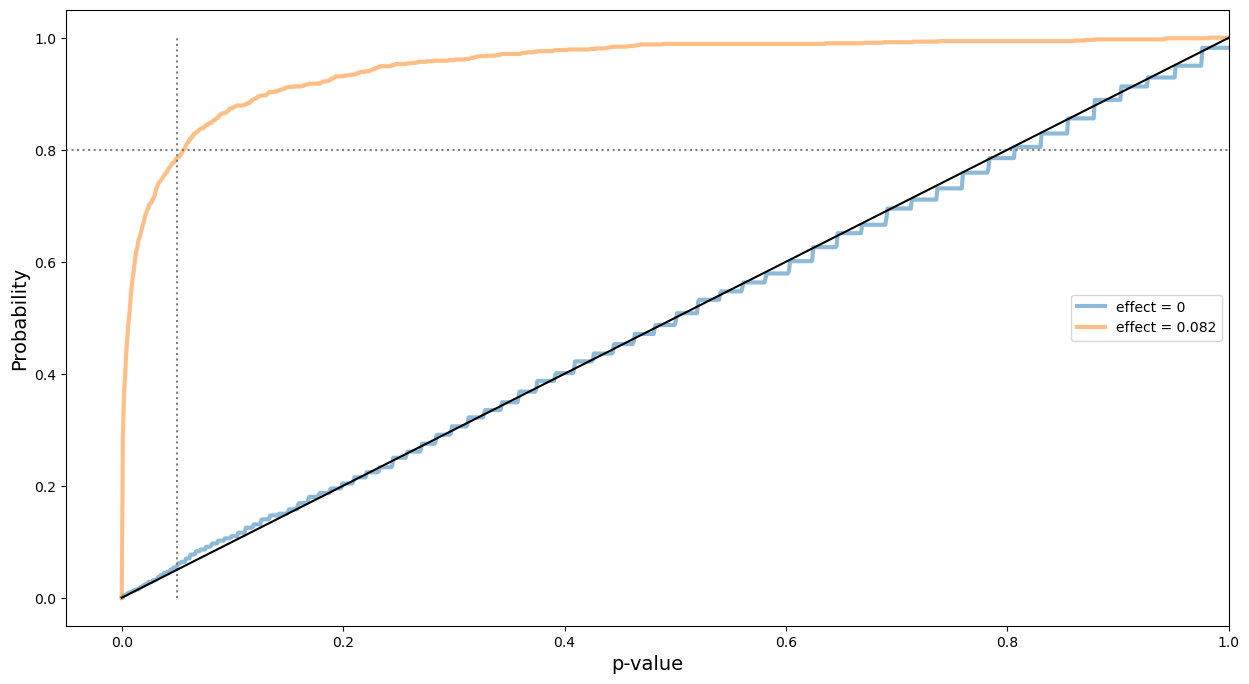

In [257]:
effects = [0, 0.082]

# Хранение p-values для каждого значения эффекта
pvalues_dict = {}

for effect in effects:
    ttl_users = math.ceil(df_subs_trial_wo_dubl['user_id'].nunique() / num_of_bucket)
    pvalues_ttest = []

        n_control = len(df_control)
        n_pilot = len(df_pilot)

        # Рассчитываем p-value через z-тест
        _, p_value = proportions_ztest([success_control, success_pilot], [n_control, n_pilot])
        pvalues_ttest.append(p_value)

    pvalues_dict[effect] = pvalues_ttest  # Сохраняем p-values для текущего эффекта

# Визуализация результатов
plt.figure(figsize=(15, 8))
X = np.linspace(0, 1, 1000)

for effect, pvalues in pvalues_dict.items():
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=f'effect = {effect}')
    print()
    print(f"Эффект = {effect}")
    print(f"Период - {'2 недели'} дней")
    print(f'Итераций с p_value < 0.05:', len([p for p in pvalues if p < 0.05]))
    print(f'Число пользователей всего:', ttl_users * 2)

plt.xlabel('p-value', size=14)
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

## Критерий  t-test

100%|██████████| 1000/1000 [00:00<00:00, 1338.91it/s]



Эффект = 0
Период - 2 недели
Итераций с p_value < 0.05: 47
Число пользователей всего: 4276

Эффект = 0.082
Период - 2 недели
Итераций с p_value < 0.05: 778
Число пользователей всего: 4276


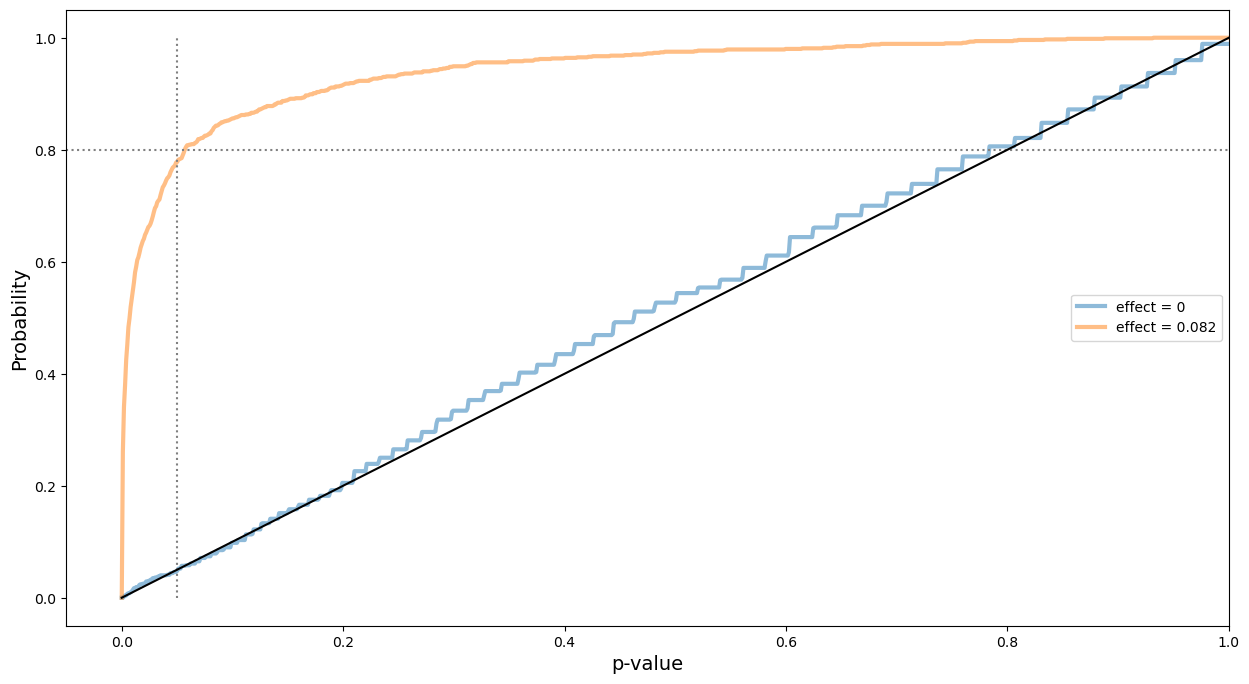

In [259]:
effects = [0, 0.082]

# Хранение p-values для каждого значения эффекта
pvalues_dict = {}


for effect in effects:
    ttl_users = math.ceil(df_subs_trial_wo_dubl['user_id'].nunique() / num_of_bucket)
    pvalues_ttest = []
    for i in tqdm(range(1000)):
    
        df_control = df_subs_trial_wo_dubl.sample(n=ttl_users, replace=True)
        df_pilot = df_subs_trial_wo_dubl.sample(n=ttl_users, replace=True)
        df_pilot = df_pilot['success_type'] * (1 + effect)

        # Проведение t-теста
        _,p_value = ttest_ind(df_control['success_type'], df_pilot)
        pvalues_ttest.append(p_value)
        
    pvalues_dict[effect] = pvalues_ttest  # Сохраняем p-values для текущего эффекта
        

# Визуализация результатов
plt.figure(figsize=(15, 8))
X = np.linspace(0, 1, 1000)

for effect, pvalues in pvalues_dict.items():
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=f'effect = {effect}')
    print()
    print(f"Эффект = {effect}")
    print(f"Период - {'2 недели'}")
    print(f'Итераций с p_value < 0.05:', len([p for p in pvalues if p < 0.05]))
    print(f'Число пользователей всего:', ttl_users * 2)

plt.xlabel('p-value', size=14)
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()


## t-тест с применением постстратификации

100%|██████████| 1000/1000 [00:04<00:00, 237.60it/s]



Эффект = 0
Период - 2 недели дней
Итераций с p_value < 0.05: 61
Число пользователей всего: 4276
----------------------------------------------------------------------------------------------------
Среднее значение выборочных дисперсий: 0.24951157782628966
Среднее значение выборочных дисперсий с применением постратификации: 0.22394346714974053
Среднее значение выборочных средних: 0.5218676333021515
Среднее значение выборочных средних с применением постратификации: 0.5213180927618492

Эффект = 0.082
Период - 2 недели дней
Итераций с p_value < 0.05: 764
Число пользователей всего: 4276
----------------------------------------------------------------------------------------------------
Среднее значение выборочных дисперсий: 0.29208531855642744
Среднее значение выборочных дисперсий с применением постратификации: 0.26227366104696176
Среднее значение выборочных средних: 0.5654062357343311
Среднее значение выборочных средних с применением постратификации: 0.5641050919464935


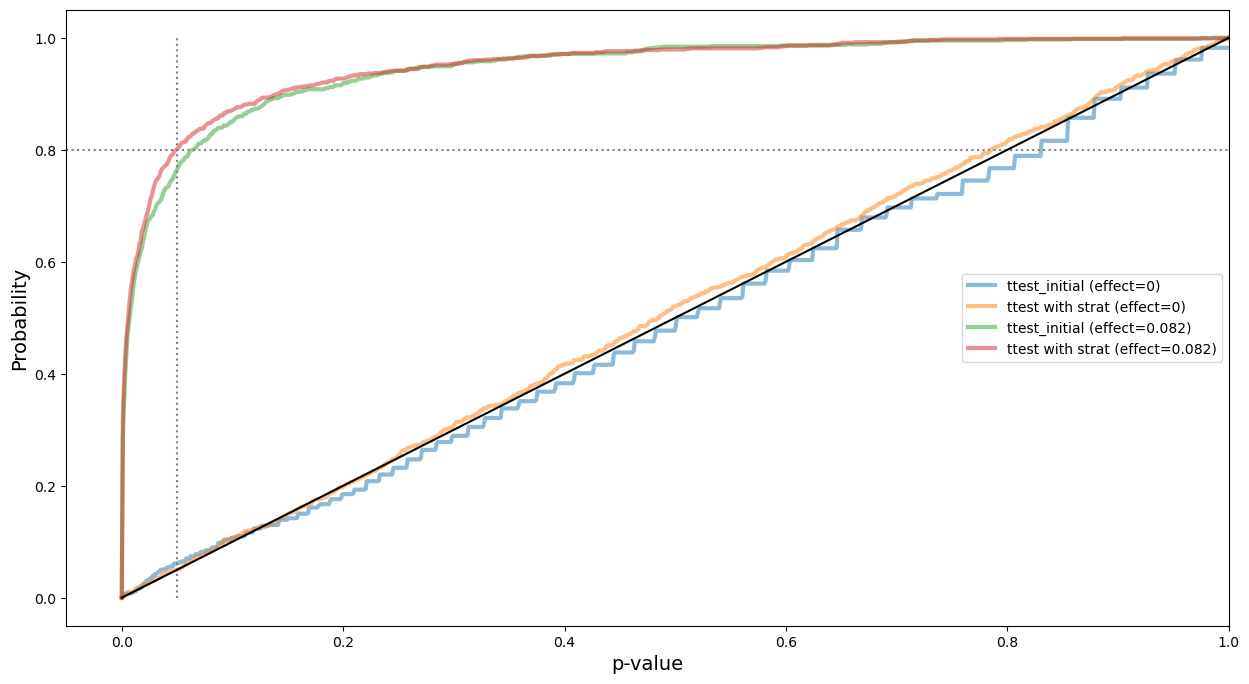

In [269]:
effects = [0, 0.082]

# Хранение результатов для каждого значения эффекта
results_dict = {effect: {'pvalues_ttest': [], 'pvalues_ttest_strat': [],
                         'var_initial': [], 'var_strat': [],
                         'mean_initial': [], 'mean_strat': []} for effect in effects}


ttl_users = math.ceil(df_subs_trial_wo_dubl['user_id'].nunique() / num_of_bucket)

for effect in effects:
    for _ in tqdm(range(1000)):
        
        # AA/AB тест без стратификации
        df_control = df_subs_trial_wo_dubl.sample(n=ttl_users, replace=True)
        df_pilot = df_subs_trial_wo_dubl.sample(n=ttl_users, replace=True)
        df_pilot['success_type'] *= (1 + effect)
        mean = df_pilot['success_type'].mean()
        var = df_pilot['success_type'].var()
        pvalue = ttest_ind(df_control['success_type'], df_pilot['success_type'])[1]

        # AA/AB тест с постстратификацией
        df_control = df_subs_trial_wo_dubl.sample(n=ttl_users, replace=True)
        df_pilot = df_subs_trial_wo_dubl.sample(n=ttl_users, replace=True)
        df_pilot['success_type'] *= (1 + effect)
        
        mean2 = calculate_stratified_mean(df_pilot, weights, 'success_type')
        var2 = calculate_strat_var(df_pilot, weights, 'success_type')
        pvalue_strat = check_stratified_test(df_control, df_pilot, weights, 'success_type')
        
        # Сохраняем результаты для текущего эффекта
        results_dict[effect]['pvalues_ttest'].append(pvalue)
        results_dict[effect]['pvalues_ttest_strat'].append(pvalue_strat)
        results_dict[effect]['var_initial'].append(var)
        results_dict[effect]['var_strat'].append(var2)
        results_dict[effect]['mean_initial'].append(mean)
        results_dict[effect]['mean_strat'].append(mean2)

# Вывод и визуализация результатов
plt.figure(figsize=(15, 8))
X = np.linspace(0, 1, 1000)


for effect in effects:
    pvalues_ttest = np.array(results_dict[effect]['pvalues_ttest'])
    pvalues_ttest_strat = np.array(results_dict[effect]['pvalues_ttest_strat'])
    var_initial = np.mean(results_dict[effect]['var_initial'])
    var_strat = np.mean(results_dict[effect]['var_strat'])
    mean_initial = np.mean(results_dict[effect]['mean_initial'])
    mean_strat = np.mean(results_dict[effect]['mean_strat'])
    
    # График для каждого эффекта
    for pvalues, title in zip([pvalues_ttest, pvalues_ttest_strat],
                              [f'ttest_initial (effect={effect})', f'ttest with strat (effect={effect})']):
        Y = [np.mean(pvalues < x) for x in X]
        plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
    
    print(f"\n{BOLD}Эффект = {effect}{END}")
    print('='*50)
    print(f"Период - {'2 недели'} дней")
    print(f'Итераций с p_value < 0.05:', len([p for p in pvalues_ttest if p < 0.05]))
    print(f'Число пользователей всего:', ttl_users * 2)
    print('--'*50)
    print("Среднее значение выборочных дисперсий:", var_initial)
    print("Среднее значение выборочных дисперсий с применением постратификации:", var_strat)  
    print("Среднее значение выборочных средних:", mean_initial)
    print("Среднее значение выборочных средних с применением постратификации:", mean_strat)

plt.xlabel('p-value', size=14)
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()


In [271]:
def zip_(list_1,list_2):
    list_3 = []
    if len(list_1)>=len(list_2):
        for i in range(len(list_2)):
            pair_tuple = (list_1[i],list_2[i])
            list_3.append(pair_tuple)
    else:
        for i in range(len(list_1)):
            pair_tuple = (list_1[i],list_2[i])
            list_3.append(pair_tuple)
    return list_3
    

In [273]:
list_1 = [1, 5, 3, 8, 35]
list_2 = [1, 5, 9, 10, 40, 1, 40]
zip_(list_1,list_2)

[(1, 1), (5, 5), (3, 9), (8, 10), (35, 40)]

In [275]:
list_3 = []
for i in zip(list_1, list_2):
    list_3.append(i)
list_3
    

[(1, 1), (5, 5), (3, 9), (8, 10), (35, 40)]

In [277]:
def final_balance(init_sum, interest_rate, years, round_num=2):
    return round(init_sum * ((100 + interest_rate)/100) ** years, round_num)

print(final_balance(init_sum = 1000, interest_rate=5, years=5))
print(final_balance(init_sum = 700, interest_rate=7, years=10))

1276.28
1377.01


In [279]:
def final_balance(init_sum, interest_rate, months, round_num=2):  
    # Преобразование годовой процентной ставки в месячную  
    monthly_rate = interest_rate / 12  
    # Расчет конечного баланса за указанный период в месяцах  
    return round(init_sum * ((1 + monthly_rate)) ** months, round_num)  

# Примеры использования функции  
print(final_balance(init_sum=1000, interest_rate=0.21, months=6))  # 5 лет = 60 месяцев  
print(final_balance(init_sum=700, interest_rate=0.7, months=12))  # 10 лет = 120 месяцев

1109.7
1382.19


In [281]:
def math_task(data):  
    answer = []  
    # возводим в третью степень  
    for elem in data:  
        answer.append(elem ** 3)  # Исправлено возведение в куб  
    print("###")  
    print(answer)  
    print("###")  

    # берем остаток от деления на 7  
    for i in range(len(answer)):  
        answer[i] = answer[i] % 7  # Исправлено на деление на 7  
    print("###")  
    print(answer)  
    print("###")  

    # прибавляем к остатку изначальный массив  
    for i in range(len(answer)):  
        answer[i] = answer[i] + data[i]  
    print("###")  
    print(answer)  
    print("###")  

    # возвращаем результат  
    return answer  

# Пример данных для тестирования  
test_data = [1, 2, 3, 4]  # Замените это на данные, которые будут выполнять проверку  
result = math_task(test_data)  
print(result)  # Печать финального результата

###
[1, 8, 27, 64]
###
###
[1, 1, 6, 1]
###
###
[2, 3, 9, 5]
###
[2, 3, 9, 5]


In [283]:
def reversed_(array):
    rv = []
    while array:
        rv.append(array.pop())
    return rv

if reversed_(reversed_([1, 2, 3])) == [1, 2, 3]:
    print("Все хорошо")
else:
    raise RuntimeError("Ошибка, после обращения дважды не получается исходный массив!")
    
arr = [1, 2, 3]
if reversed_(reversed_(arr)) == arr:
    print("Все хорошо")
else:
    raise RuntimeError("Ошибка, после обращения дважды не получается исходный массив!")

Все хорошо


RuntimeError: Ошибка, после обращения дважды не получается исходный массив!

In [285]:
arr = [1, 2, 3]
if reversed_(reversed_(arr)) == arr:
    print("Все хорошо")
else:
    raise RuntimeError("Ошибка, после обращения дважды не получается исходный массив!")

RuntimeError: Ошибка, после обращения дважды не получается исходный массив!

In [287]:
def reversed_(array):  
    rv = []  
    for item in array:  
        rv.insert(item)  # Вставляем элемент в начало нового списка  
    return rv  

In [289]:
list = [1,2,3,4,3,1,10,100,10,100,100,100,2]
d = {}
for i in list:
    if i in d:
        d[i]+=1
    else:
        d[i]=1
print(d)

{1: 2, 2: 2, 3: 2, 4: 1, 10: 2, 100: 4}


In [291]:
from collections import Counter

Counter(list)

Counter({100: 4, 1: 2, 2: 2, 3: 2, 10: 2, 4: 1})